# THINGS - NGC5236 (M83) - Cold HI gas - Lower limit

# Libraries

In [1]:
import os
import sys
import glob
import pickle

import seaborn as sns
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.io.votable import from_table, parse_single_table, parse
from matplotlib.ticker import AutoMinorLocator
from scipy import interpolate
from scipy.odr import Model, ODR, RealData

In [2]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

from astropy.wcs import WCS
from spectral_cube import SpectralCube
import pywt

In [ ]:
from numpy.fft import rfftn
from tqdm import tqdm

In [3]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.wcs import utils

In [4]:
# sns.set(style="whitegrid")
# sns.set_context("paper")
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

In [5]:
# plt.rc('font', weight='bold')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
# plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
mpl.rcParams['axes.linewidth'] = 2.

In [6]:
pd.set_option("display.max_columns", None)

In [7]:
import bisect

# Insert new element to the right order
a = [3, 4, 6, 8, 9, 11, 22]

val = 7

idx = bisect.bisect(a, val)
print(idx)

a.insert(idx, val)
print(a)

# or 1 line
bisect.insort(a, val)
print(a)

3
[3, 4, 6, 7, 8, 9, 11, 22]
[3, 4, 6, 7, 7, 8, 9, 11, 22]


# Paths

In [8]:
base = os.path.expanduser('~')
askap = os.path.join(base, 'ANU', 'ASKAP')
LMC = os.path.join(askap, 'LMC')
LMC_plots = os.path.join(LMC, 'plots')
data_path = os.path.join(askap, 'data')
LMC_data_path = os.path.join(data_path, 'LMC')
LMC_bridge_data = os.path.join(LMC_data_path, 'bridge')
LMC_GASKAP_data = os.path.join(LMC_data_path, 'lmc_gaskap')
LMC_imaging_data = os.path.join(LMC_data_path, 'imaging')

GASS_data_path = os.path.join(LMC_data_path, 'GASS')

gfit_path = os.path.join(LMC, 'gfit')
gfit_result_path = os.path.join(gfit_path, 'results')
LMC_abs_component_path = os.path.join(LMC_data_path, "absorption")


typhoon = os.path.join(data_path, 'typhoon')
tp_hi_data_path = os.path.join(typhoon, 'hi')

things = os.path.join(data_path, 'things')
things_hi_data_path = os.path.join(things, 'hi')
things_hi_data_path

'/Users/kiemhiep/ANU/ASKAP/data/things/hi'

# Fcn

In [9]:
def read_fits_cube(filename):
    """
    Read 

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """
        
    # Read FITS file
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube
    
    # c = c[:, 10:29, 10:29]

    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header
    # w = WCS(hdr)
    
    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]


    dat.close()  # Close the FITS file - we already read it in and don't need it anymore!

    print(f"Cube shape: {c.shape}") # (vlsr, b, l) : (971, 201, 376)

    del dat
    # cube = cube.with_spectral_unit(u.km / u.s)
    
    _, _, x = c.world[0, 0, :]      # extract RA: deg
    _, y, _ = c.world[0, :, 0]     # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]    # extract velocity
    
    return c, w, x, y, v, hdr

In [10]:
def Jy2K(flux, a, b, freq=1.420405750):
    """
    Convert mJy/beam to Kelvin 

    Parameters
    ----------
    Flux (float) : Flux in unit of mJy/beam
    a (float) : Major axis in unit of arcsec
    b (float) : Minor axis in unit of arcsec

    Returns
    -------
    Brightness temperatur Tb in Kelvin

    Other parameters
    ----------------
    None
    """
    bmaj = a*u.arcsec
    bmin = b*u.arcsec
    fwhm_to_sigma = 1./(8*np.log(2))**0.5
    beam_area = 2.*np.pi*(bmaj*bmin*fwhm_to_sigma**2)
    freq = freq*u.GHz
    equiv = u.brightness_temperature(freq)
    return (flux*u.Jy/beam_area).to(u.K, equivalencies=equiv)

In [ ]:
def not_zero_counts(a):
    '''
    Counts of non-zero values
    '''
    return (a > 0).sum()

In [ ]:
def apodize_1d(radius, size):
    """                                                                                                                                                                                                                                                               
    Create edges apodization tapper 1d
    
    Parameters
    ----------
    nx : integer
    size of the tapper
    radius : float
    radius must be lower than 1 and greater than 0.
    
    Returns
    -------
    
    tapper : numpy array ready to multiply on your spectrum
    to apodize edges     
    """

    if (radius >= 1) or (radius <= 0.):
        print('Error: radius must be lower than 1 and greater than 0.')
        return

    nj = np.fix(radius*size)
    dnj = int(size-nj)

    tap1d_x = np.ones(size)

    tap1d_x[0:dnj] = np.cos(3.*np.pi/2. + np.pi/2. * (1.* np.arange( dnj )/(dnj-1)) )
    tap1d_x[size-dnj:] = np.cos(0. + np.pi/2. * (1.* np.arange(dnj)/(dnj-1)) )

    return tap1d_x

# Resolution and noise

In [11]:
ngc5236_data_path = os.path.join(things, 'NGC_5236', 'AIPS')
ngc5236_data_path

'/Users/kiemhiep/ANU/ASKAP/data/things/NGC_5236/AIPS'

In [12]:
NA_a = 15.16 # arcsec
NA_b = 11.44
NA_pa = -3. # deg
NA_noise = 0.83 # mJy/beam

RO_a = 10.4 # arcsec
RO_b = 5.6
RO_pa = 0.5
RO_noise = 0.98

# THINGS Robust weighted image

In [14]:
dfile = 'N5236_10_RO.MA_BLA.1.FITS'
filename = os.path.join(ngc5236_data_path, dfile)
filename

'/Users/kiemhiep/ANU/ASKAP/data/things/NGC_5236/AIPS/N5236_10_RO.MA_BLA.1.FITS'

In [16]:
subcube, cube_wcs, subcube_ra, subcube_dec, subcube_vlsr, hdr = read_fits_cube(filename)
print(cube_wcs)
print(subcube)

Cube shape: (123, 1024, 1024)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 204.25515982  -29.8712066437  
CRPIX : 512.0  513.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0004166666768  0.0004166666768  
NAXIS : 0  0
SpectralCube with shape=(123, 1024, 1024) and unit=Jy / beam:
 n_x:   1024  type_x: RA---SIN  unit_x: deg    range:   204.009108 deg:  204.501782 deg
 n_y:   1024  type_y: DEC--SIN  unit_y: deg    range:   -30.084796 deg:  -29.657582 deg
 n_s:    123  type_s: VOPT-F2W  unit_s: m / s  range:   355202.185 m / s:  670621.665 m / s


In [17]:
freq = hdr['RESTFREQ']
freq

1420405750.0

In [18]:
subcube_vlsr = np.array(subcube_vlsr.to(u.km/u.s))
print(subcube_vlsr[:3], '...', subcube_vlsr[-3:])

[670.62166477 668.03356454 665.44550889] ... [360.36765669 357.78489855 355.20218485]


In [19]:
data = np.array(subcube)
data.shape

(123, 1024, 1024)

In [ ]:
# channel_width = 2.58
hi_flux = np.nansum(data, axis=(1, 2))

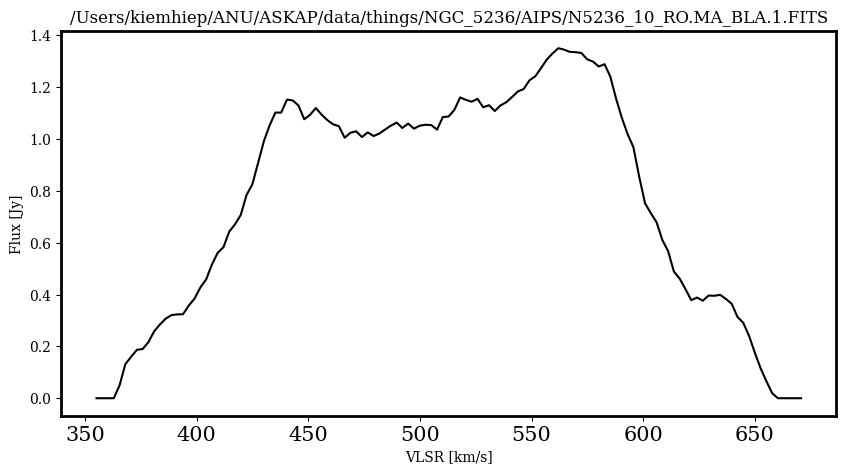

In [21]:
fig = plt.figure(figsize=(10,5))

plt.plot(subcube_vlsr, hi_flux, 'k-')

plt.title(filename)
plt.xlabel('VLSR [km/s]')
plt.ylabel('Tb [K]')
plt.ylabel('Flux [Jy]')
fig.savefig(filename.replace('.FITS', '_global_spectrum.jpg'), bbox_inches='tight')   # save the figure to file
plt.show()

In [22]:
mom0 = subcube.with_spectral_unit(u.km/u.s).moment(order=0)  # Zero-th moment 
mom1 = subcube.with_spectral_unit(u.km/u.s).moment(order=1)  # First moment
mom2 = subcube.with_spectral_unit(u.km/u.s).moment(order=2)  # 2nd moment

/Users/kiemhiep/opt/anaconda3/envs/gfit/lib/python3.10/site-packages/spectral_cube/_moments.py:87: RuntimeWarning: invalid value encountered in divide
  return result / weights
/Users/kiemhiep/opt/anaconda3/envs/gfit/lib/python3.10/site-packages/spectral_cube/_moments.py:87: RuntimeWarning: invalid value encountered in divide
  return result / weights


In [23]:
print('Moment_0 has units of: ', mom0.unit)
print('Moment_1 has units of: ', mom1.unit)
print('Moment_2 has units of: ', mom2.unit)

Moment_0 has units of:  Jy km / (beam s)
Moment_1 has units of:  km / s
Moment_2 has units of:  km2 / s2


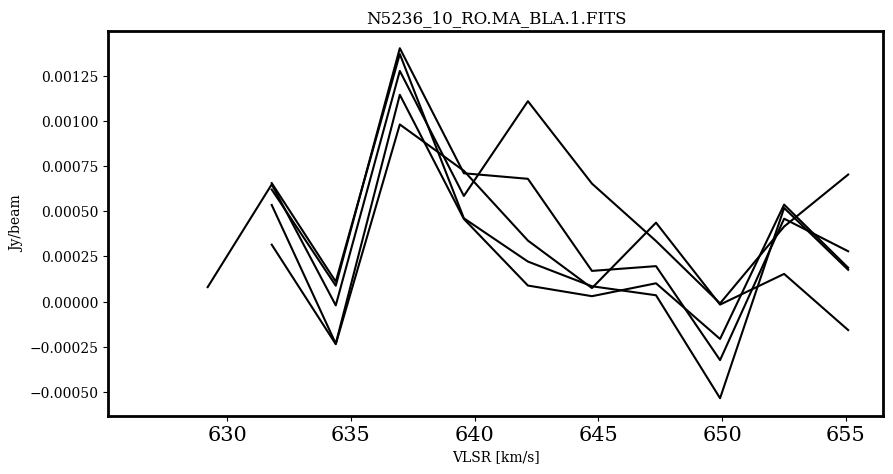

In [24]:
plt.figure(figsize=(10,5))

for i in range(5):
    plt.plot(subcube_vlsr, data[:, 200+i, 800+i], 'k-')

plt.title(dfile)
plt.xlabel('VLSR [km/s]')
plt.ylabel('Jy/beam')
plt.show()

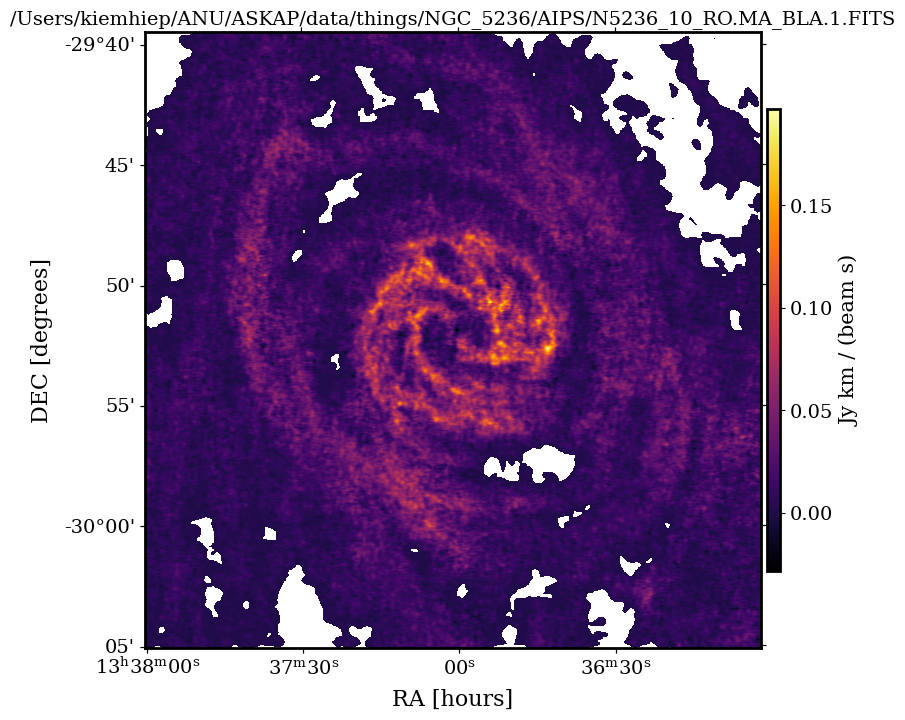

In [25]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection=mom0.wcs)

# moment map image
im = ax.imshow(np.array(mom0), cmap='inferno')

# Title
ax.set_title(filename, fontsize=14)

# Add axes labels
ax.set_xlabel("RA [hours]", fontsize=16)
ax.set_ylabel("DEC [degrees]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
# cbar.ax.set_ylabel('N(HI) [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.set_ylabel(mom0.unit, rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

# plt.legend(loc='upper left', fontsize=12)
# plt.grid()
plt.show()

/var/folders/gm/swhrysh52t997rq3klc2d7f80000gr/T/ipykernel_28366/759578955.py:6: RuntimeWarning: invalid value encountered in log10
  im = ax.imshow(np.log10(np.array(mom1)), cmap='inferno')


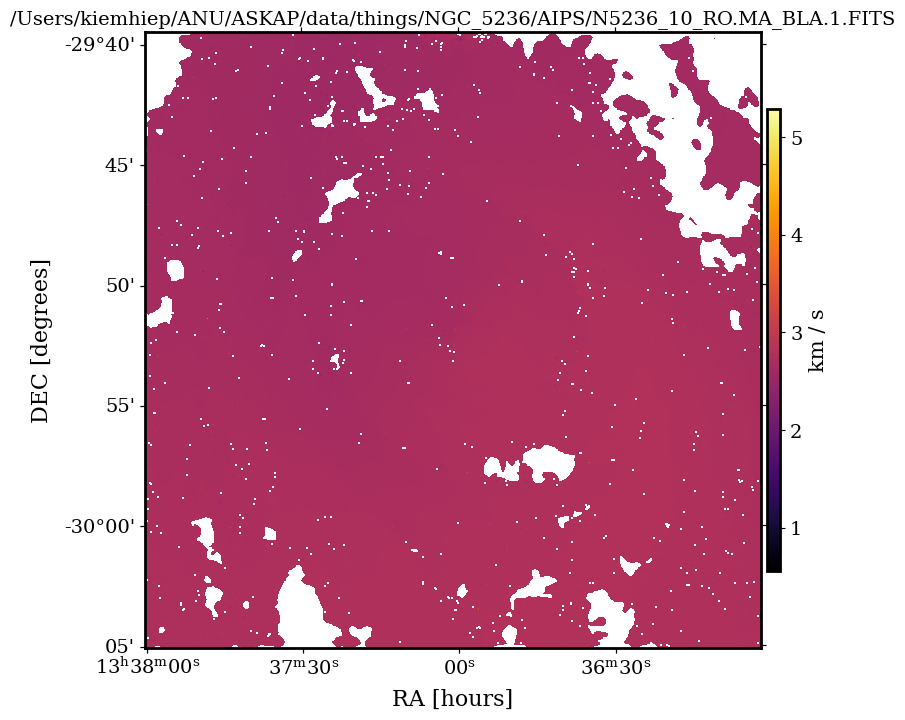

In [26]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection=mom0.wcs)

# moment map image
im = ax.imshow(np.log10(np.array(mom1)), cmap='inferno')

# Title
ax.set_title(filename, fontsize=14)

# Add axes labels
ax.set_xlabel("RA [hours]", fontsize=16)
ax.set_ylabel("DEC [degrees]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
# cbar.ax.set_ylabel('N(HI) [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.set_ylabel(mom1.unit, rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

# plt.legend(loc='upper left', fontsize=12)
# plt.grid()
plt.show()

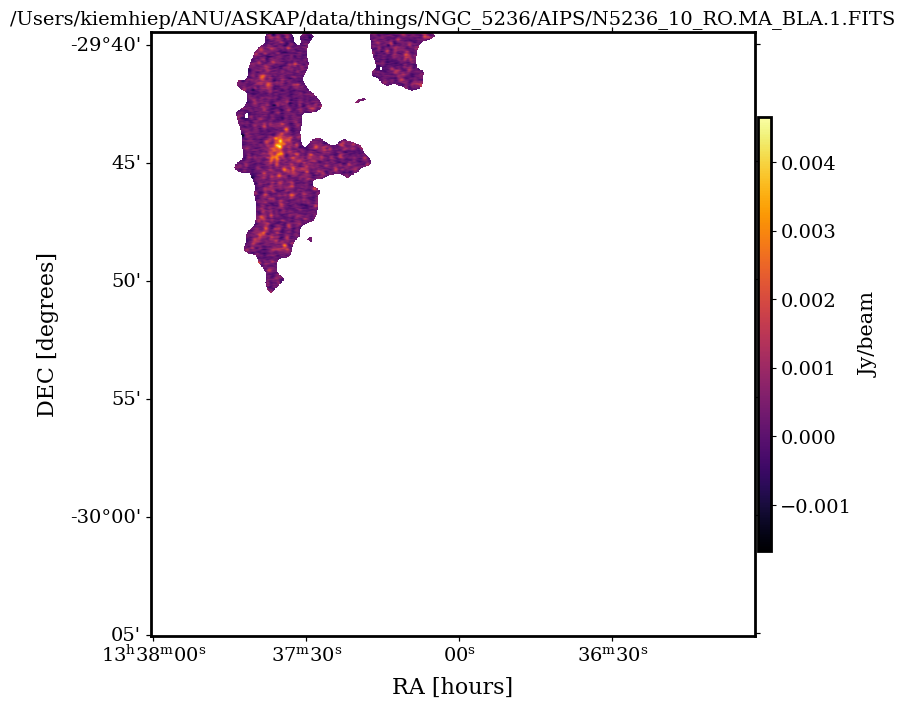

In [30]:
# Plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection=mom0.wcs)

# moment map image
im = ax.imshow(data[106, :, :], cmap='inferno')

# Title
ax.set_title(filename, fontsize=14)

# Add axes labels
ax.set_xlabel("RA [hours]", fontsize=16)
ax.set_ylabel("DEC [degrees]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
# cbar.ax.set_ylabel('N(HI) [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.set_ylabel('Jy/beam', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

# plt.legend(loc='upper left', fontsize=12)
# plt.grid()
plt.show()

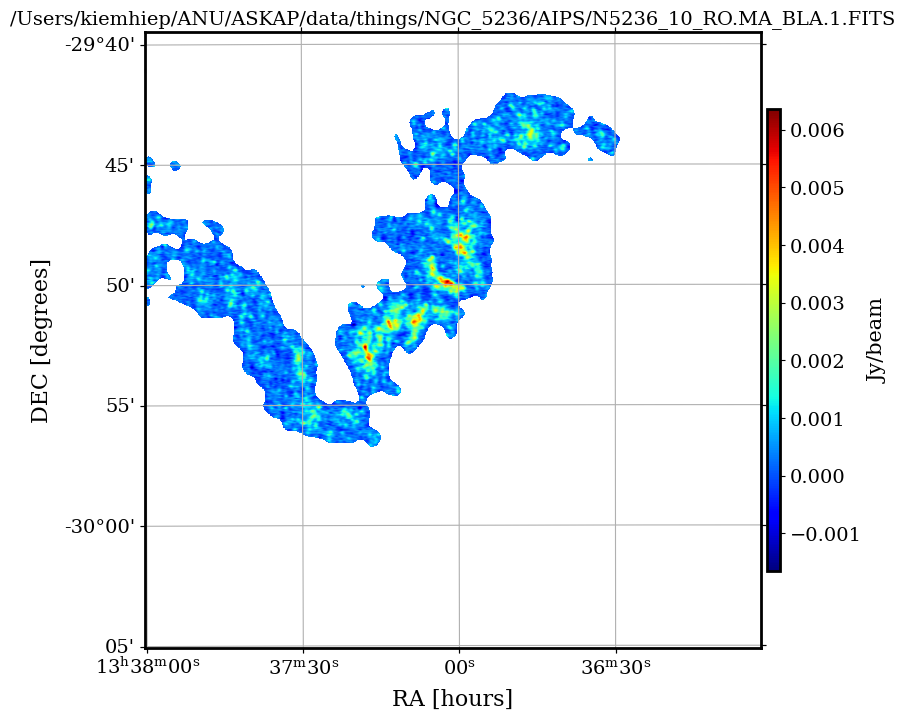

In [37]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection=mom0.wcs)

# moment map image
im = ax.imshow(data[80, :, :], cmap='jet')
# im = ax.imshow(moment_0, cmap='jet', norm=mpl.colors.LogNorm(1., 100.))

# Title
ax.set_title(filename, fontsize=14)

# Add axes labels
ax.set_xlabel("RA [hours]", fontsize=16)
ax.set_ylabel("DEC [degrees]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
# cbar.ax.set_ylabel('N(HI) [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.set_ylabel('Jy/beam', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

# plt.legend(loc='upper left', fontsize=12)
plt.grid()
plt.show()

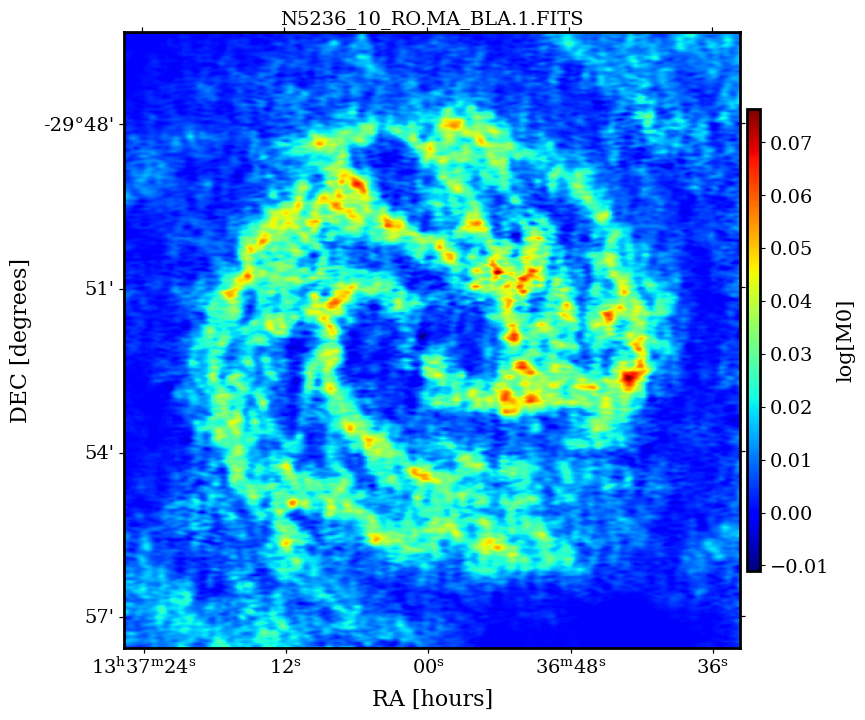

In [38]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection=mom0.wcs)

# moment map image
im = ax.imshow(np.nansum(data, axis=0), cmap='jet')

# Title
ax.set_title(dfile, fontsize=14)

# Add axes labels
ax.set_xlabel("RA [hours]", fontsize=16)
ax.set_ylabel("DEC [degrees]", fontsize=16)
ax.tick_params(labelsize=14)

ax.set_xlim(300., 750.)
ax.set_ylim(300., 750.)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
# cbar.ax.set_ylabel('N(HI) [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.set_ylabel('log[M0]', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

# plt.legend(loc='upper left', fontsize=12)
# plt.grid()
fig.savefig(filename.replace('.FITS', '_zoom.jpg'), bbox_inches='tight')   # save the figure to file
plt.show()
plt.close()

# THINGS Natural weighted image

In [39]:
# Convert the FWHM from arcseconds to radians
NA_a_rad = np.radians(NA_a / 3600)
NA_b_rad = np.radians(NA_b / 3600)

# Compute the beam area in steradians
beam_area_str = np.pi * NA_a_rad * NA_b_rad / (4. * np.log(2))

print(f"Beam area in steradians: {beam_area_str}")

Beam area in steradians: 4.618908720246898e-09


In [41]:
dfile = 'N5236_NA_RES.MA_BLA.1.FITS'
filename = os.path.join(ngc5236_data_path, dfile)
filename

'/Users/kiemhiep/ANU/ASKAP/data/things/NGC_5236/AIPS/N5236_NA_RES.MA_BLA.1.FITS'

In [43]:
subcube, cube_wcs, subcube_ra, subcube_dec, subcube_vlsr, hdr = read_fits_cube(filename)
print(cube_wcs)
print(subcube)

Cube shape: (123, 1024, 1024)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 204.25515982  -29.8712066437  
CRPIX : 512.0  513.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0004166666768  0.0004166666768  
NAXIS : 0  0
SpectralCube with shape=(123, 1024, 1024) and unit=Jy / beam:
 n_x:   1024  type_x: RA---SIN  unit_x: deg    range:   204.009108 deg:  204.501782 deg
 n_y:   1024  type_y: DEC--SIN  unit_y: deg    range:   -30.084796 deg:  -29.657582 deg
 n_s:    123  type_s: VOPT-F2W  unit_s: m / s  range:   355202.185 m / s:  670621.665 m / s


In [44]:
freq = hdr['RESTFREQ']
freq

1420405750.0

In [45]:
subcube_vlsr = np.array(subcube_vlsr.to(u.m/u.s))
print(subcube_vlsr[:3], '...', subcube_vlsr[-3:])

[670621.66477185 668033.56453836 665445.50889087] ... [360367.65669096 357784.89854783 355202.1848526 ]


In [46]:
subcube_vlsr /= 1000.

In [47]:
# Spectral resolution
dv = np.abs(np.diff(subcube_vlsr).mean())
dv

2.5854055731086456

In [48]:
subcube.unit

Unit("Jy / beam")

In [49]:
data = np.array(subcube)
data.shape

(123, 1024, 1024)

In [50]:
nchan, ny, nx = data.shape
print(nchan, ny, nx)

123 1024 1024


In [51]:
data = np.nan_to_num(data, nan=0.)

Convert Jy/beam to Kelvin

In [52]:
tb = data * 6.07e5 / NA_a / NA_b

In [53]:
tb[np.where(tb < 0.)] = 0.

In [55]:
pos_counts = np.apply_along_axis(not_zero_counts, 0, tb)
print(pos_counts.shape)

(1024, 1024)


In [56]:
xidx, yidx = np.where(pos_counts < 3)
print(xidx.shape)
print(yidx.shape)
print(len(yidx)/np.prod(pos_counts.shape))

(152971,)
(152971,)
0.14588451385498047


In [57]:
tb[:, xidx, yidx] = 0.

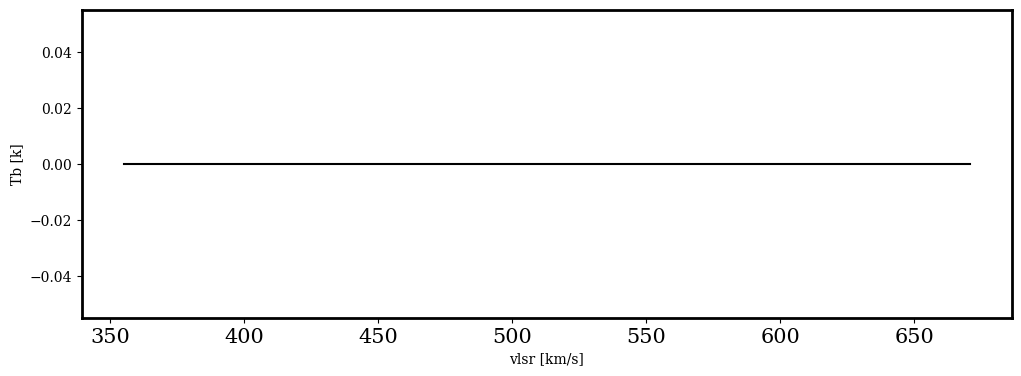

In [58]:
f, ax1 = plt.subplots(1, 1, figsize=(12,4)) 
j = xidx[10000]
i = yidx[10000]
ax1.plot(subcube_vlsr, tb[:,j,i], "-k")
ax1.set_ylabel('Tb [k]')
ax1.set_xlabel('vlsr [km/s]')
plt.show()

In [59]:
NHI = np.sum(tb, axis=0) * dv * 1.82243e-2

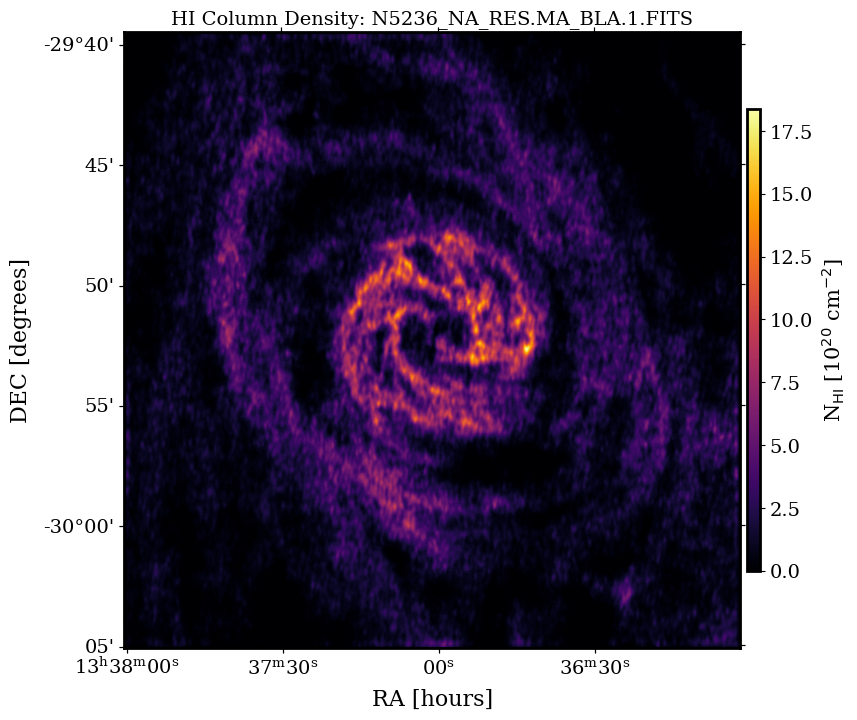

In [60]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection=mom0.wcs)

# moment map image
im = ax.imshow(NHI, cmap='inferno')

# Title
ax.set_title('HI Column Density: ' + dfile, fontsize=14)

# Add axes labels
ax.set_xlabel("RA [hours]", fontsize=16)
ax.set_ylabel("DEC [degrees]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel('N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
# cbar.ax.set_ylabel(mom0.unit, rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

# plt.legend(loc='upper left', fontsize=12)
# plt.grid()
plt.show()

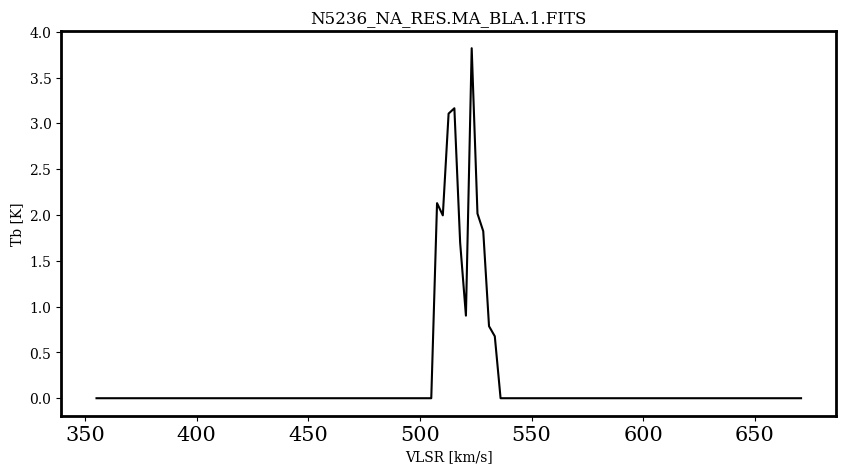

In [61]:
plt.figure(figsize=(10,5))

plt.plot(subcube_vlsr, tb[:, 333, 123], 'k-')

plt.title(dfile)
plt.xlabel('VLSR [km/s]')
plt.ylabel('Tb [K]')
plt.show()

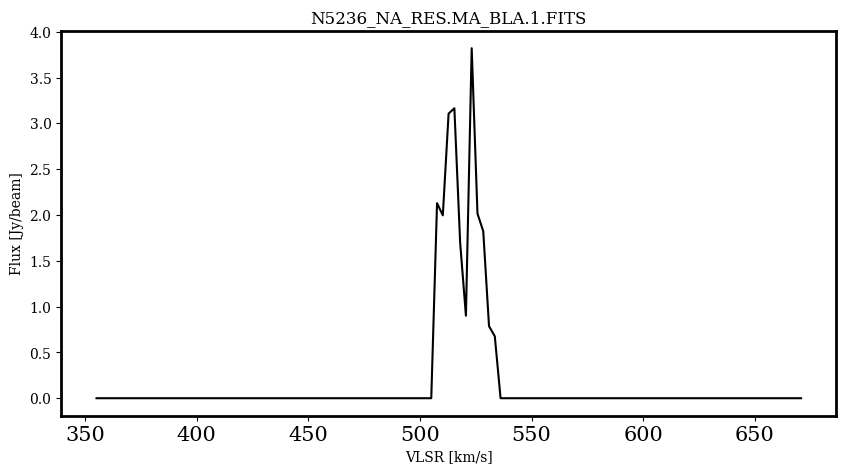

In [62]:
fig = plt.figure(figsize=(10,5))

plt.plot(subcube_vlsr, tb[:, 333, 123], 'k-')

plt.title(dfile)
plt.xlabel('VLSR [km/s]')
plt.ylabel('Tb [K]')
plt.ylabel('Flux [Jy/beam]')
fig.savefig(filename.replace('.FITS', '_spectrum_333_123.jpg'), bbox_inches='tight')   # save the figure to file
plt.show()

In [63]:
xidx, yidx = np.where(NHI < 0.75)
print(xidx.shape)
print(yidx.shape)
print(len(yidx)/np.prod(pos_counts.shape))

(451791,)
(451791,)
0.4308614730834961


In [64]:
tb[:, xidx, yidx] = 0.

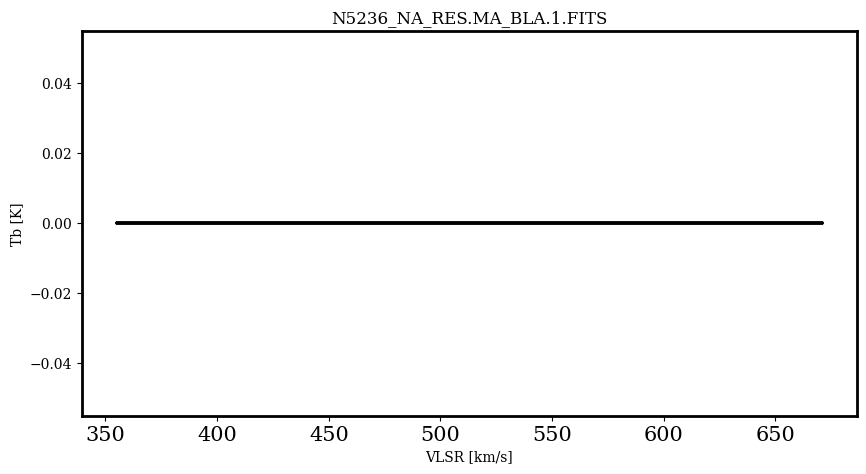

In [65]:
plt.figure(figsize=(10,5))

for i in range(50):
    plt.plot(subcube_vlsr, tb[:, yidx[i], xidx[i]], 'k-')

plt.title(dfile)
plt.xlabel('VLSR [km/s]')
plt.ylabel('Tb [K]')
plt.show()

# HI column density (opticall-thin assumption)

In [66]:
NHI = np.sum(tb, axis=0) * dv * 1.82243e-2

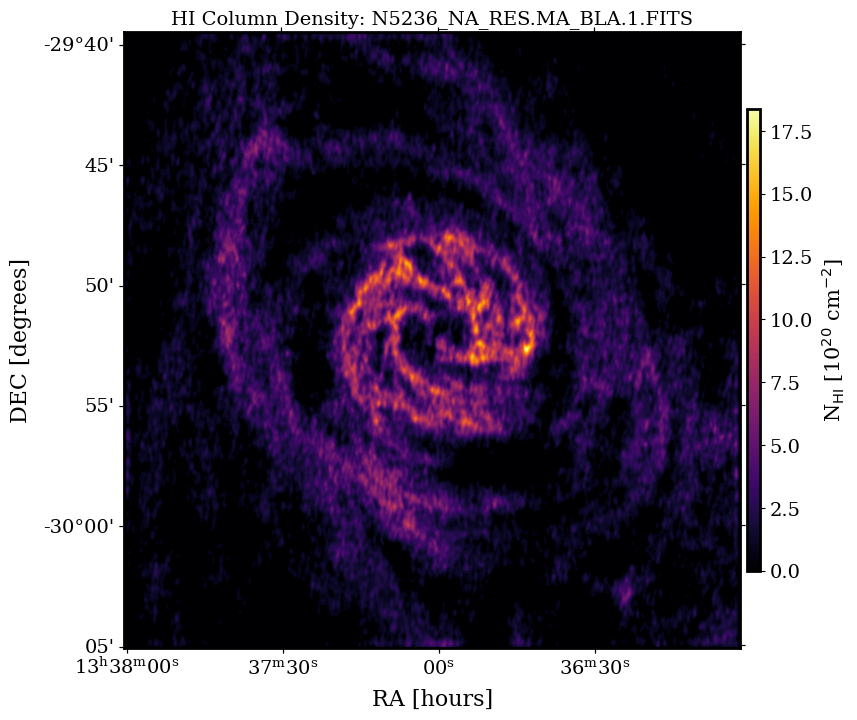

In [67]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection=mom0.wcs)

# moment map image
im = ax.imshow(NHI, cmap='inferno')

# Title
ax.set_title('HI Column Density: ' + dfile, fontsize=14)

# Add axes labels
ax.set_xlabel("RA [hours]", fontsize=16)
ax.set_ylabel("DEC [degrees]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel('N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
# cbar.ax.set_ylabel(mom0.unit, rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

# plt.legend(loc='upper left', fontsize=12)
# plt.grid()
plt.show()

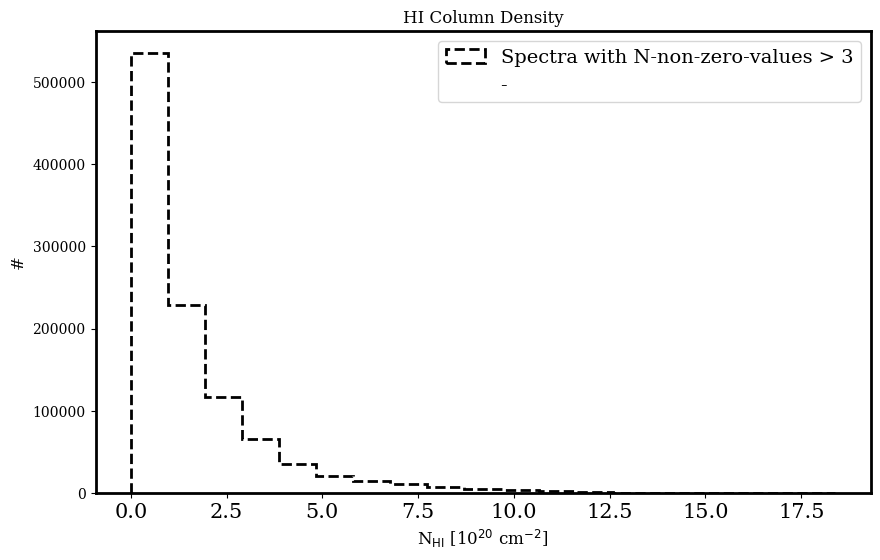

In [68]:
# from scipy import stats
plt.figure(figsize=(10, 6))

nhi_flatten = NHI.flatten()

nhi_min = np.min(nhi_flatten)
nhi_max = np.max(nhi_flatten)

counts, bins, bars = plt.hist(nhi_flatten,
                              bins=np.linspace(nhi_min, nhi_max, 20),
         density=False, color='k', histtype='step', alpha=1.,
         ls='--', lw=2, label=r'Spectra with N-non-zero-values > 3')

ploti, = plt.plot([], [], '', label=f"-")
ploti.set_visible(False)

plt.title('HI Column Density')
plt.xlabel('N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=12)
plt.ylabel(r'#', fontsize=12)

plt.legend(loc='upper right', fontsize=14)
plt.show()

# Cold HI gas fraction: Lower limit (See Antoine's paper on Fourier Transform)

In [76]:
print(dv)

2.5854055731086456


In [78]:
#Fourier all cube along v axis
hfreqs = np.fft.rfftfreq(nchan, dv)
nfreqs = len(hfreqs)

hsfft = np.zeros((nfreqs, ny, nx))
for i,j in tqdm(np.ndindex(nx,ny)):
        s = tb[:,i,j]
        
        #Apodization
        tapper = apodize_1d(0.9, nchan)
        s_apod = s * tapper
        hsfft[:,i,j] = np.abs(rfftn(s_apod))
        
        #Normalization by total NHI (FFT at k=0)
        hsfft[:,i,j] /= hsfft[0,i,j]

0it [00:00, ?it/s]/var/folders/gm/swhrysh52t997rq3klc2d7f80000gr/T/ipykernel_28366/186071769.py:15: RuntimeWarning: invalid value encountered in divide
  hsfft[:,i,j] /= hsfft[0,i,j]
1048576it [00:44, 23738.50it/s]


In [79]:
#Selected kv cut (see paper)
# kcut = 0.12
kcut = 0.08

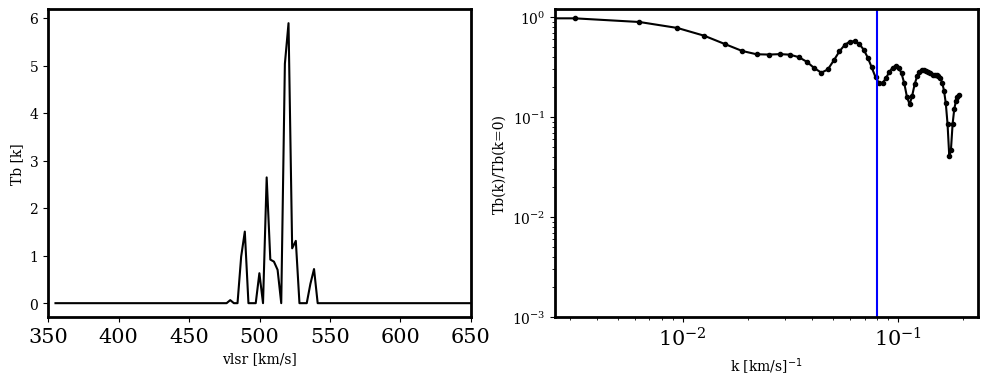

In [80]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4)) 
i = 500
j = 500
ax1.plot(subcube_vlsr, tb[:,j,i], "-k")
ax1.set_ylabel('Tb [k]')
ax1.set_xlabel('vlsr [km/s]')
ax1.set_xlim(350., 650.)

ax2.plot(hfreqs, hsfft[:,j,i], ".-k")
ax2.plot([kcut, kcut], [0,2], "-b")
ax2.set_ylim([1.e-3,1.2])
ax2.set_ylabel('Tb(k)/Tb(k=0)')
ax2.set_xlabel('k [km/s]$^{-1}$')
ax2.set_xscale("log")
ax2.set_yscale("log")

plt.show()

In [81]:
klim = np.where(np.sort(hfreqs) > kcut)[0][0]
print(klim, hfreqs[klim])

26 0.08175975019926027


In [82]:
hsfft[klim:].shape

(36, 1024, 1024)

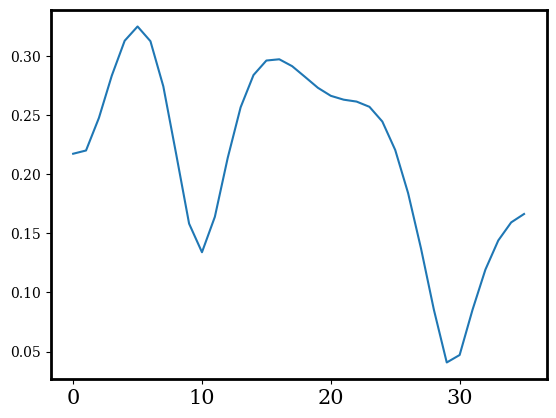

In [83]:
plt.figure()
plt.plot(hsfft[klim:][:, 500,500])
plt.show()

In [84]:
fcnm_low = np.max(hsfft[klim:], 0)
fcnm_low = np.nan_to_num(fcnm_low, nan=0.)

In [85]:
np.max(fcnm_low)

0.9994583033146736

In [96]:
xindx, yindx = np.where(fcnm_low > 0.8)

In [88]:
len(yindx)

143

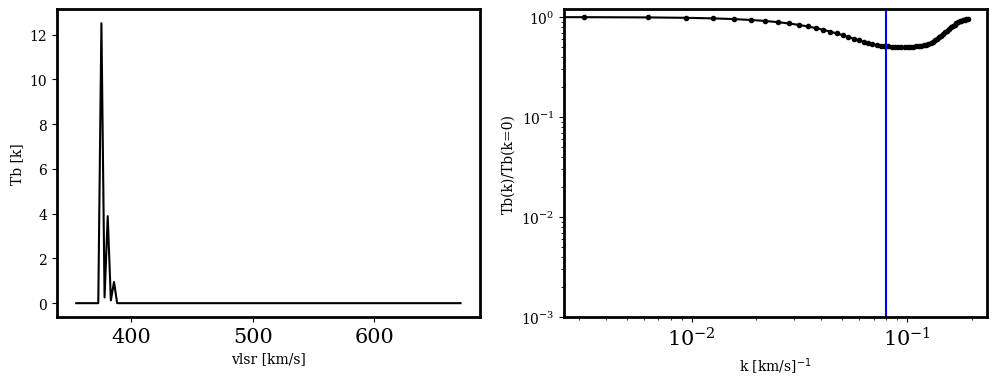

In [89]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4)) 
i = yindx[100]
j = xindx[100]
ax1.plot(subcube_vlsr, tb[:,j,i], "-k")
ax1.set_ylabel('Tb [k]')
ax1.set_xlabel('vlsr [km/s]')
ax2.plot(hfreqs, hsfft[:,j,i], ".-k")
ax2.plot([kcut, kcut], [0,2], "-b")
ax2.set_ylim([1.e-3,1.2])
ax2.set_ylabel('Tb(k)/Tb(k=0)')
ax2.set_xlabel('k [km/s]$^{-1}$')
ax2.set_xscale("log")
ax2.set_yscale("log")

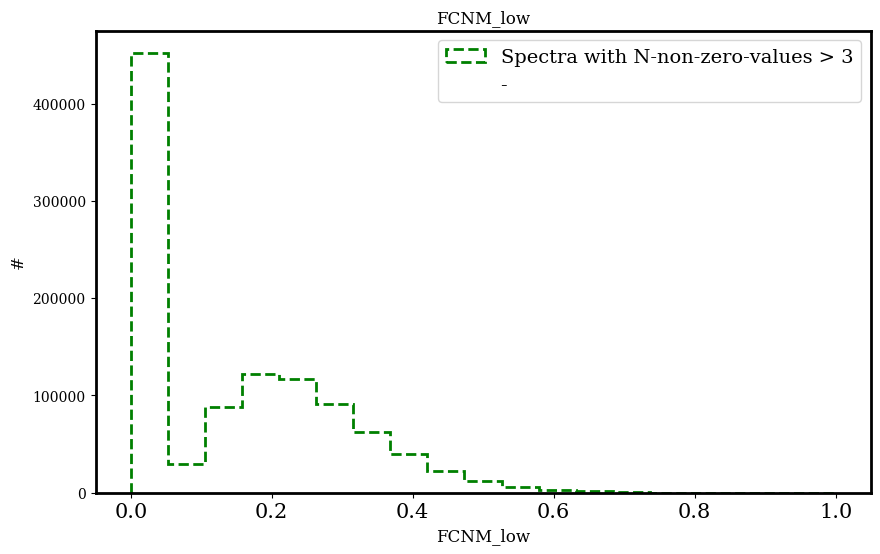

In [90]:
# from scipy import stats
plt.figure(figsize=(10, 6))

fcnm_low_flatten = fcnm_low.flatten()

fcnm_min = np.min(fcnm_low_flatten)
fcnm_max = np.max(fcnm_low_flatten)

counts, bins, bars = plt.hist(fcnm_low_flatten,
                              bins=np.linspace(fcnm_min, fcnm_max, 20),
         density=False, color='g', histtype='step', alpha=1.,
         ls='--', lw=2, label=r'Spectra with N-non-zero-values > 3')

ploti, = plt.plot([], [], '', label=f"-")
ploti.set_visible(False)

plt.title(f'FCNM_low')
plt.xlabel(r'FCNM_low', fontsize=12)
plt.ylabel(r'#', fontsize=12)

plt.legend(loc='upper right', fontsize=14)
plt.show()

In [91]:
fcnm_uplim = 0.8
fcnm_low[fcnm_low > fcnm_uplim] = 0.

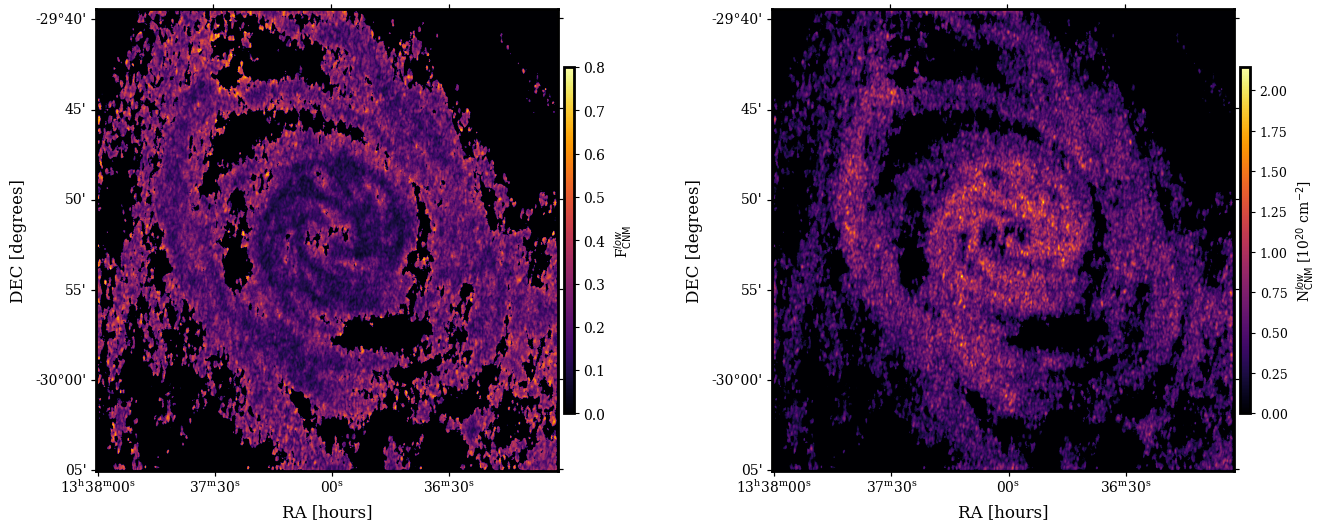

In [92]:
#Plot mass fraction map
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121, projection=mom0.wcs)

im = ax1.imshow(fcnm_low, vmin=0., vmax=fcnm_uplim, cmap="inferno")
# Add axes labels
ax1.set_xlabel("RA [hours]", fontsize=12)
ax1.set_ylabel("DEC [degrees]", fontsize=12)
ax1.tick_params(labelsize=10)

## Color bar
cbar = fig.colorbar(im, ax=ax1, orientation='vertical', shrink=0.75, fraction=0.05, pad=0.01, aspect=35)
cbar.ax.set_ylabel('F$^{low}_\mathrm{CNM}$', rotation=90, labelpad=5., fontsize=10)
# cbar.ax.set_ylabel(mom0.unit, rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=10)


ax2 = fig.add_subplot(122, projection=mom0.wcs)

im2 = ax2.imshow(fcnm_low*NHI, vmin=0., cmap="inferno")

# Add axes labels
ax2.set_xlabel("RA [hours]", fontsize=12)
ax2.set_ylabel("DEC [degrees]", fontsize=12)
ax2.tick_params(labelsize=10)

## Color bar
cbar = fig.colorbar(im2, ax=ax2, orientation='vertical', shrink=0.75, fraction=0.05, pad=0.01, aspect=35)
cbar.ax.set_ylabel('N$^{low}_\mathrm{CNM}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=10)
# cbar.ax.set_ylabel(mom0.unit, rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=9)

plt.show()

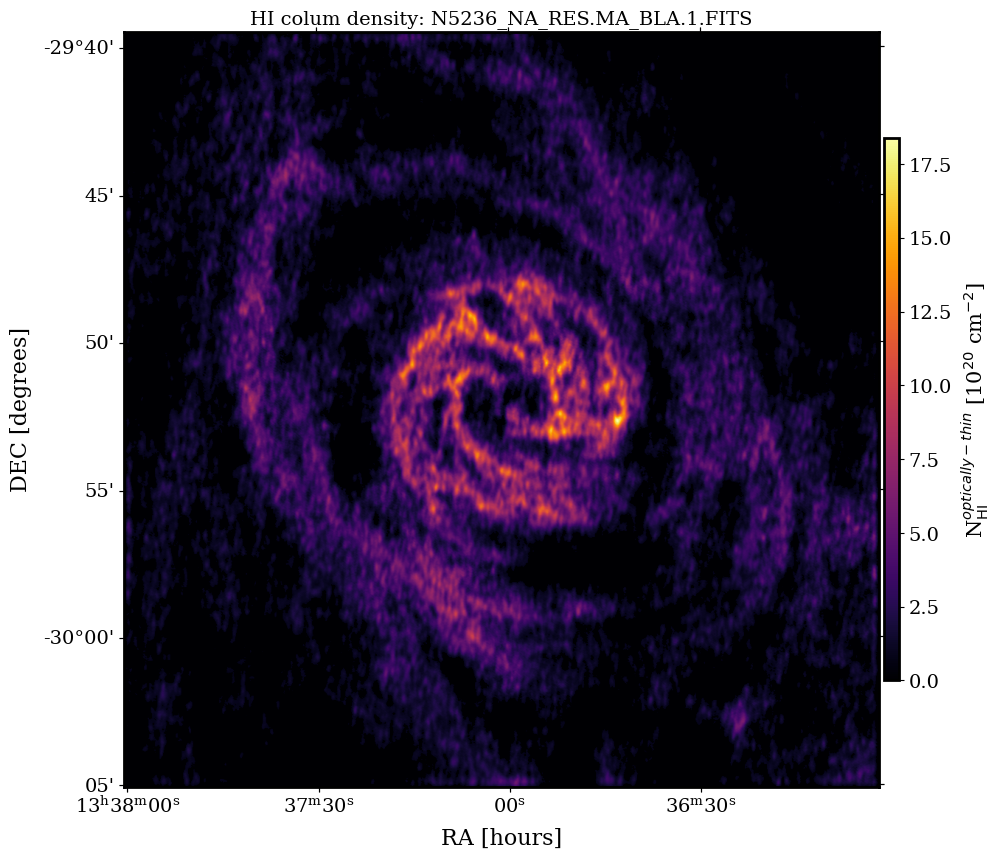

In [93]:
# Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=mom0.wcs)

# moment map image
im = ax.imshow(NHI, cmap='inferno')

# Title
ax.set_title('HI colum density: ' + dfile, fontsize=14)

# Add axes labels
ax.set_xlabel("RA [hours]", fontsize=16)
ax.set_ylabel("DEC [degrees]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel('N$^{optically-thin}_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
# cbar.ax.set_ylabel(mom0.unit, rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

# plt.legend(loc='upper left', fontsize=12)
# plt.grid()
plt.show()

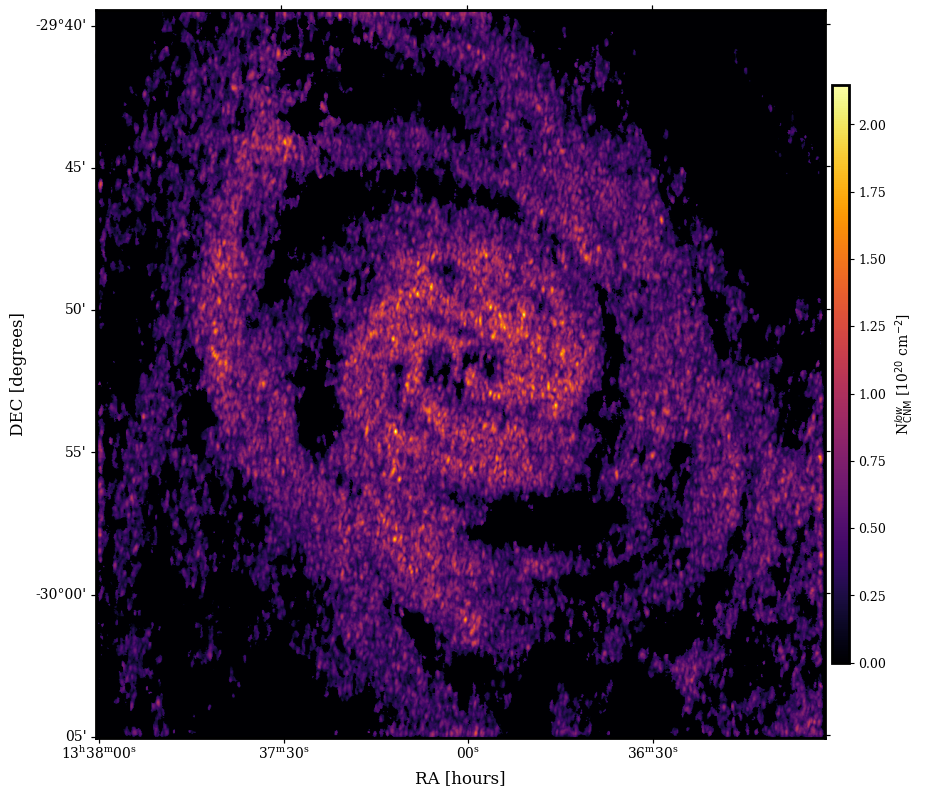

In [94]:
#Plot mass fraction map
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, projection=mom0.wcs)

im2 = ax1.imshow(fcnm_low*NHI, vmin=0., cmap="inferno")

# Add axes labels
ax1.set_xlabel("RA [hours]", fontsize=12)
ax1.set_ylabel("DEC [degrees]", fontsize=12)
ax1.tick_params(labelsize=10)

## Color bar
cbar = fig.colorbar(im2, ax=ax1, orientation='vertical', shrink=0.75, fraction=0.05, pad=0.01, aspect=35)
cbar.ax.set_ylabel('N$^{low}_\mathrm{CNM}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=10)
# cbar.ax.set_ylabel(mom0.unit, rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=9)

plt.show()